In [1]:
#import all the necessary packages for the Project
import os
import shutil
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import time

import logging
import torch
import torch.nn as nn
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from collections import Counter


from skimage.feature import hog
from skimage.io import imread
from skimage.color import rgb2gray
import mahotas  
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTEENN
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Hyperparameters
# Batch size for training and validation
batch_size = 32  
# Number of epochs
num_epochs = 20  
# Initial learning rate
learning_rate = 1e-3  
# Learning rate decay 
learning_rate_decay = 0.9  
# Weight decay for regularization
reg = 1e-4  
# set fine-tune ResNet to True instead of using frozen weights
fine_tune = True 
# set pre-trained to true and use pre-trained weights for ResNet 
pretrained = True  

# Dataset directory
data_path = '/Users/hobelle/Desktop/Math156/reduced_dataset'  # Path to the dataset

#configuration
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print("Using device:", device)

# Data augmentation and preprocessing
data_aug_transforms = transforms.Compose([
    # flip images horizontally randomly
    transforms.RandomHorizontalFlip(),  
     # Resize images 
    transforms.Resize((256, 256)), 
    # crop to 224x224 pixels (random regions)
    transforms.RandomCrop(224),  
    transforms.ToTensor(),
     # Normalize using ImageNet's mean and standard deviation
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

# Load dataset
def load_dataset():
    """
    This is a funtion to load the dataset and split it into training, validation, and test sets. 
    This function shoudl return the data, the full data set; train_dataset, the set for training; 
    val_dataset, the set for validation; test_dataset, which is the set for testing. 
    """
    dataset = torchvision.datasets.ImageFolder(root=data_path, transform=data_aug_transforms)

    # Ensure splits are consistent
    total_samples = len(dataset)
    num_train = int(0.6 * total_samples)
    num_val = int(0.2 * total_samples)
    num_test = total_samples - num_train - num_val
    lengths = [num_train, num_val, num_test]

    train_dataset, val_dataset, test_dataset = random_split(dataset, lengths)
    return dataset, train_dataset, val_dataset, test_dataset

dataset, train_dataset, val_dataset, test_dataset = load_dataset()
print(f"Total samples: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# WeightedRandomSampler is used to handle class imbalance
class_counts = Counter([label for _, label in train_dataset])
class_weights = [1.0 / class_counts[c] for c in range(len(class_counts))]
sample_weights = [class_weights[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Define model  
class ResNetModel(nn.Module):
    """
    Class to fine-tune different versions of ResNet.

    Attributes:
        model (torchvision.models): The pre-trained ResNet model.
    """
    def __init__(self, num_classes, resnet_version, pretrained=True):
        """
        This function initializez each ResNet model for fine-tuning. The inputs 
            num_classes (int): Number of output classes.
            resnet_version (int): Version of ResNet (50, 101, 152).
            pretrained (bool): Whether to use pre-trained weights.
        """
        super(ResNetModel, self).__init__()
        if resnet_version == 50:
            resnet = models.resnet50(pretrained=pretrained)
        elif resnet_version == 101:
            resnet = models.resnet101(pretrained=pretrained)
        elif resnet_version == 152:
            resnet = models.resnet152(pretrained=pretrained)
        else:
            raise ValueError("Invalid ResNet version")
        
        if fine_tune:
            for param in resnet.parameters():
                param.requires_grad = False
        
        num_ftrs = resnet.fc.in_features
        resnet.fc = nn.Linear(num_ftrs, num_classes)
        self.model = resnet

    def forward(self, x):
        """
        This function is the Forward pass of the model.The input of the function is x (torch.Tensor) which is the input tensor.The function shoudl return torch.Tensor.
        """
        return self.model(x)


import time
import matplotlib.pyplot as plt

# Initialize models
models_to_train = {
    "ResNet-50": ResNetModel(num_classes=len(dataset.classes), resnet_version=50, pretrained=pretrained).to(device),
    "ResNet-101": ResNetModel(num_classes=len(dataset.classes), resnet_version=101, pretrained=pretrained).to(device),
    "ResNet-152": ResNetModel(num_classes=len(dataset.classes), resnet_version=152, pretrained=pretrained).to(device)
    # "EfficientNet-B7": EfficientNetModel(num_classes=len(dataset.classes), pretrained=pretrained).to(device)
}

# Train models
f1_scores = {}
training_times = {}

def train_model(model, model_name):
    """
    This funciton trains the specified model(s) and save the best-performing one. 
    The input arguments to this function is the ResNet model to train and the model name. 
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=learning_rate_decay)

    best_f1 = 0.0
    start_time = time.time()  # Start timing the training process

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()
        
        # Validation
        model.eval()
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        f1 = f1_score(all_labels, all_preds, average='weighted')
        print(f"Epoch [{epoch+1}/{num_epochs}] {model_name}, Validation F1 Score: {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), f"{model_name}.pth")
            print(f"New best model saved for {model_name} with F1: {best_f1:.4f}")

    end_time = time.time()  # End timing the training process
    training_time = end_time - start_time

    f1_scores[model_name] = best_f1
    training_times[model_name] = training_time
    print(f"Training time for {model_name}: {training_time:.2f} seconds")

# Train and save all models
for model_name, model in models_to_train.items():
    print(f"Training {model_name}...")
    train_model(model, model_name)

Using device: mps
Total samples: 3614
Training samples: 2168
Validation samples: 722
Test samples: 724


/Users/hobelle/miniforge3/envs/pytorch_1/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hobelle/miniforge3/envs/pytorch_1/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/hobelle/miniforge3/envs/pytorch_1/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_

Training ResNet-50...
Epoch [1/20] ResNet-50, Validation F1 Score: 0.5365
New best model saved for ResNet-50 with F1: 0.5365
Epoch [2/20] ResNet-50, Validation F1 Score: 0.5627
New best model saved for ResNet-50 with F1: 0.5627
Epoch [3/20] ResNet-50, Validation F1 Score: 0.5828
New best model saved for ResNet-50 with F1: 0.5828
Epoch [4/20] ResNet-50, Validation F1 Score: 0.5684
Epoch [5/20] ResNet-50, Validation F1 Score: 0.5983
New best model saved for ResNet-50 with F1: 0.5983
Epoch [6/20] ResNet-50, Validation F1 Score: 0.5557
Epoch [7/20] ResNet-50, Validation F1 Score: 0.5771
Epoch [8/20] ResNet-50, Validation F1 Score: 0.6275
New best model saved for ResNet-50 with F1: 0.6275
Epoch [9/20] ResNet-50, Validation F1 Score: 0.6384
New best model saved for ResNet-50 with F1: 0.6384
Epoch [10/20] ResNet-50, Validation F1 Score: 0.5922
Epoch [11/20] ResNet-50, Validation F1 Score: 0.6171
Epoch [12/20] ResNet-50, Validation F1 Score: 0.6029
Epoch [13/20] ResNet-50, Validation F1 Score:

KeyboardInterrupt: 

In [4]:
def load_trained_model(model_name, num_classes):
    """
    Reinitialize the specified model architecture and load the trained weights.
    """
    if model_name == "ResNet-50":
        model = ResNetModel(num_classes=num_classes, resnet_version=50, pretrained=False).to(device)
        model.load_state_dict(torch.load('Resnet-50.pth'))
    elif model_name == "ResNet-101":
        model = ResNetModel(num_classes=num_classes, resnet_version=101, pretrained=False).to(device)
        model.load_state_dict(torch.load('Resnet-101.pth'))
    elif model_name == "ResNet-152":
        model = ResNetModel(num_classes=num_classes, resnet_version=152, pretrained=False).to(device)
        model.load_state_dict(torch.load('Resnet-152.pth'))
    else:
        raise ValueError(f"Unknown model: {model_name}")
    return model

# Reload the models and evaluate
trained_models = {
    "ResNet-50": load_trained_model("ResNet-50", num_classes=len(dataset.classes)),
    "ResNet-101": load_trained_model("ResNet-101", num_classes=len(dataset.classes)),
    "ResNet-152": load_trained_model("ResNet-152", num_classes=len(dataset.classes)),
}

<Figure size 1000x1000 with 0 Axes>

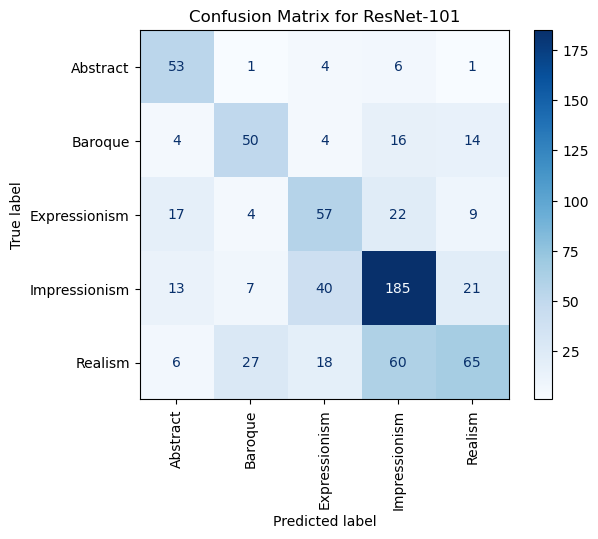

In [5]:
def evaluate_model(model, test_loader, model_name):
    """
    Evaluate the model on the test dataset.
    Args:
        model: Trained model to evaluate.
        test_loader: DataLoader for the test dataset.
        model_name: Name of the model (for logging purposes).

    Returns:
        y_true: True labels.
        y_pred: Predicted labels.
    """
    y_true = []
    y_pred = []

    # Ensure the model is in evaluation mode
    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    return y_true, y_pred

trained_models = {
    "ResNet-50": load_trained_model("ResNet-50", num_classes=len(dataset.classes)),
    "ResNet-101": load_trained_model("ResNet-101", num_classes=len(dataset.classes)),
    "ResNet-152": load_trained_model("ResNet-152", num_classes=len(dataset.classes)),
}

y_true_resnet101, y_pred_resnet101 = evaluate_model(trained_models["ResNet-101"], test_loader, "ResNet-101")

# Generate confusion matrix
cm = confusion_matrix(y_true_resnet101, y_pred_resnet101)
cmd = ConfusionMatrixDisplay(cm, display_labels=dataset.classes)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
cmd.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix for ResNet-101")
plt.show()